### Logistic regression med dummie encoding

In [3]:
import pandas as pd
import seaborn as sns

df = sns.load_dataset("titanic")

df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [7]:
df.shape 

(891, 15)

In [9]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


<Axes: >

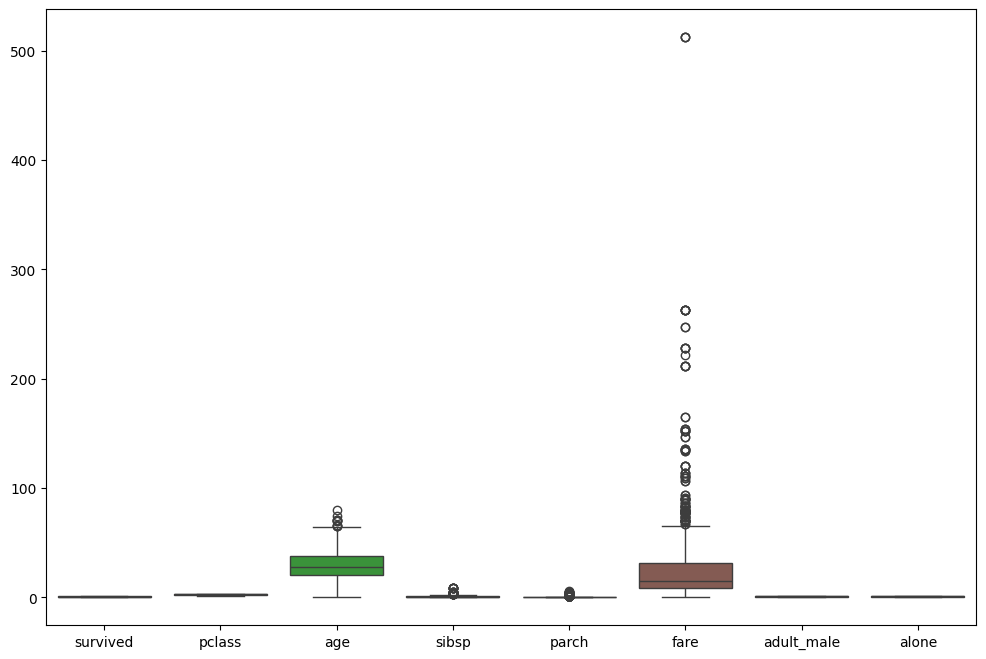

In [12]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize = (12, 8))
sns.boxplot(df)




In [22]:
y = df["survived"] # => Target/målvariabel

X = df[["sex", "class", "embarked", "age", "fare"]].copy() # Valda features (både numeriska och kategoriska)

print(X.isnull().sum()) # Kolla på nullvärden

sex           0
class         0
embarked      2
age         177
fare          0
dtype: int64


In [ ]:
# Bearbeta datan för att få bort null-värden.

X["age"] = X["age"].fillna(X["age"].median()) #Fyller 'age' med median-värde

X["embarked"] = X["embarked"].fillna(X["embarked"].mode()[0]) #Fyller 'embarked' med vanligaste värdet

print(X.isnull().sum()) #skriver ut nullvärdena igen - ska nu vara noll null-värden


sex         0
class       0
embarked    0
age         0
fare        0
dtype: int64


##### Dela upp datan i train och test

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,     # => Jämnar ut fördelningen av test/train, så fördelningen inte blir ojämn
    random_state=42
)

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Shapes: (712, 5) (179, 5) (712,) (179,)


##### ColumnTransformer (dummy-encoding + scaling)
- Delar upp features i numeriska och kategoriska
- Använder ColumnTransformer för att:
    - skala numeriska kolumner (age, fare)
    - one-hot-encoda kategoriska (sex, class, embarked)

    Resultat: varje kategori blir ett set med binära kolumner (sex_male, class_Second, class_Third, embarked_Q, embarked_S, …).

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


# Definiera vilka kolumner som är numeriska och vilka som är kategoriska
num_cols = ["age", "fare"]
cat_cols = ["sex", "class", "embarked"]

# Skapa en ColumnTransformer
preprocessor = ColumnTransformer(               # => preprocessorn = ett objekt som vet vilka kolumner som ska skalas, vilka som ska one-hote-encodas och hur datan ska byggas ihop till ny matris
    transformers =[
        ("num", StandardScaler(), num_cols),    # => Transformer: StandardScaler() → gör z-transformering (medel = 0, std = 1).
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols) # OneHotEncoder(...) → omvandlar kategoriska kolumner (sex, class, embarked) till dummy-variabler
    ]                                                                           # drop="first" → tar bort första dummy-kolumnen för varje kategori, för att undvika “perfekt multikollinaritet” (annars skulle en kategori kunna förutsägas exakt av de andra).
)                                                                               # handle_unknown="ignore" → om det dyker upp en kategori i testdatan som inte fanns i train (ovanligt men möjligt) → krascha inte, bara ignorera.



##### Pipeline med logistic regression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipe = Pipeline(steps=[
    ("prep", preprocessor),  # ColumnTransformer som skapades i föregående steg
    ("clf", LogisticRegression(
        max_iter=1000,        
        solver="lbfgs",
        random_state=42
    ))
])

# Träna på train-datan (rå X_train och y_train — pipen sköter allt)
pipe.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Utvärdera

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd

# 1) Prediktioner
y_pred = pipe.predict(X_test)

# 2) Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")

# 3) Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix (rader = sanna, kolumner = predikterade):")
print(pd.DataFrame(cm, index=["died(0)", "survived(1)"], columns=["pred 0", "pred 1"]))

# 4) Classification report
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["died", "survived"]))


Accuracy: 0.771

Confusion matrix (rader = sanna, kolumner = predikterade):
             pred 0  pred 1
died(0)          92      18
survived(1)      23      46

Classification report:
              precision    recall  f1-score   support

        died       0.80      0.84      0.82       110
    survived       0.72      0.67      0.69        69

    accuracy                           0.77       179
   macro avg       0.76      0.75      0.75       179
weighted avg       0.77      0.77      0.77       179



##### Genomgång  --> se vilka kategorier och numeriska features som väger tyngst i modellen (kod från ChatGPT)

In [20]:
import numpy as np

# 1) Hämta transformer-objekten
ohe = pipe.named_steps["prep"].named_transformers_["cat"]

# 2) Hämta one-hot feature-namn
ohe_features = ohe.get_feature_names_out(["sex", "class", "embarked"])

# 3) Slå ihop med numeriska features
all_features = np.concatenate([num_cols, ohe_features])

print("Totala features efter preprocessing:")
print(all_features)


Totala features efter preprocessing:
['age' 'fare' 'sex_male' 'class_Second' 'class_Third' 'embarked_Q'
 'embarked_S']


In [21]:
# 1) Hämta koefficienterna från Logistic Regression
coefs = pipe.named_steps["clf"].coef_[0]   # [0] eftersom binär klassificering

# 2) Lägg i en DataFrame
coef_df = pd.DataFrame({
    "feature": all_features,
    "coefficient": coefs
}).sort_values(by="coefficient", ascending=False)

print(coef_df)


        feature  coefficient
5    embarked_Q     0.250317
1          fare     0.087380
0           age    -0.411240
6    embarked_S    -0.504432
3  class_Second    -0.780339
4   class_Third    -2.042619
2      sex_male    -2.437506


##### Tolkning av ovanstående

- Positiva koefficienter → ökar sannolikheten för survived=1.

- Negativa koefficienter → ökar sannolikheten för died=0.

- Exempel (vanligt på Titanic):

- sex_male → negativ koefficient (män hade lägre chans att överleva).

- class_Third → negativ (3:e klass sämre chans).

- fare → positiv (dyrare biljett → högre chans).

- age → ofta svagt negativ (äldre → något lägre chans).

##### Barplot (chatGPT-kod...)

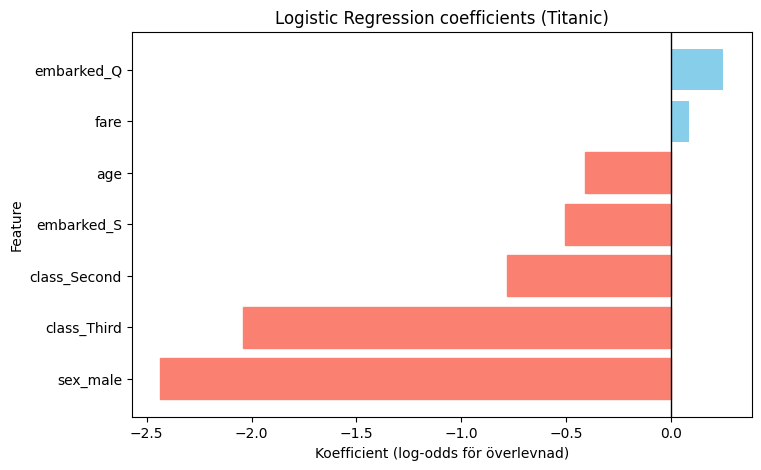

In [23]:
import matplotlib.pyplot as plt

# Sortera efter koefficient för tydligare visualisering
coef_df_sorted = coef_df.sort_values(by="coefficient")

plt.figure(figsize=(8,5))
bars = plt.barh(coef_df_sorted["feature"], coef_df_sorted["coefficient"], color="skyblue")

# Färga positiva/negativa olika
for bar, val in zip(bars, coef_df_sorted["coefficient"]):
    if val < 0:
        bar.set_color("salmon")

plt.axvline(0, color="black", linewidth=1)
plt.title("Logistic Regression coefficients (Titanic)")
plt.xlabel("Koefficient (log-odds för överlevnad)")
plt.ylabel("Feature")
plt.show()
